In [1]:
import os
import sys
import copy
import codecs
from glob import glob
from datetime import datetime
import random

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 12

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA = "../input/sleep-state"
PP_DATA = "../input/eeg-fpz-cz/eeg_fpz_cz/eeg_fpz_cz"
WINDOW_SIZE = 100
bs = 64

In [5]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-wdmi6za3
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-wdmi6za3
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras_contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101060 sha256=e55264527292386dd8f2393e689b11c88182c0855a542159a81fbd37d4f93679
  Stored in directory: /tmp/pip-ephem-wheel-cache-qhqy_mut/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras_contrib


In [7]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [8]:
!pip install mne

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_auc_score, roc_curve

import mne
from mne.io import read_raw_edf

In [10]:
fnames = sorted(glob(os.path.join(PP_DATA, "*.npz")))

In [11]:
len(fnames)

39

In [12]:
fnames[0]

'../input/eeg-fpz-cz/eeg_fpz_cz/eeg_fpz_cz/SC4001E0.npz'

In [13]:
total_fs = [f for f in fnames if f.split("/")[-1][:5]]

In [14]:
len(total_fs), total_fs[0]

(39, '../input/eeg-fpz-cz/eeg_fpz_cz/eeg_fpz_cz/SC4001E0.npz')

In [15]:
total_data = {k: np.load(k) for k in total_fs}

In [16]:
samples = total_data["../input/eeg-fpz-cz/eeg_fpz_cz/eeg_fpz_cz/SC4001E0.npz"]

In [17]:
samples['x'].shape

(841, 3000, 1)

In [18]:
X = np.zeros((0, 3000, 1))
y = []
for fn in total_fs:
    samples = np.load(fn)
    X_data = samples["x"]
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples["y"])
y = np.array(y)

In [19]:
X.shape

(42308, 3000, 1)

In [20]:
y.shape

(42308,)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42
)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42
)

In [23]:
X_train.shape, X_test.shape, X_val.shape

((34269, 3000, 1), (4231, 3000, 1), (3808, 3000, 1))

In [24]:
def rescale_array(X):
    X = X / 20
    X = np.clip(X, -5, 5)
    return X

def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, scale=True, aug=False):
    while True:
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']

        for i in range(10):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

            X = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]

            X = np.expand_dims(X, 0)
            Y = np.expand_dims(Y, -1)
            Y = np.expand_dims(Y, 0)

            if aug:
                X = aug_X(X)
                
            if scale:
                X = rescale_array(X)

            yield np.squeeze(X, axis=0), np.squeeze(Y, axis=0)

In [25]:
def data_generator(X, y, batch_size):
    indices = np.arange(len(X))
    while True:
        np.random.shuffle(indices)
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch_indices = indices[start:end]
            batch_X = preprocess_data(X[batch_indices])  # Preprocess data as needed
            batch_y = y[batch_indices]
            yield batch_X, batch_y


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D,Concatenate


In [27]:
def build_sleep_eegnet(input_shape):
    model = Sequential()
    
    # Block 1
    model.add(Conv1D(64, kernel_size=30, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # Block 2
    model.add(Conv1D(128, kernel_size=30, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # Block 3
    model.add(Conv1D(256, kernel_size=30, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # LSTM layer
    model.add(LSTM(128, return_sequences=True))
    
    # Fully Connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax')) 

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [28]:
def evaluate_metrics(cm,classes):

    print ("Confusion matrix:")
    print (cm)

    cm = cm.astype(np.float32)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)
    # ACC_micro = (sum(TP) + sum(TN)) / (sum(TP) + sum(FP) + sum(FN) + sum(TN))
    ACC_macro = np.mean(ACC) # to get a sense of effectiveness of our method on the small classes we computed this average (macro-average)

    F1 = (2 * PPV * TPR) / (PPV + TPR)
    F1_macro = np.mean(F1)

    print ("Sample: {}".format(int(np.sum(cm))))
    n_classes = len(classes)
    for index_ in range(n_classes):
        print ("{}: {}".format(classes[index_], int(TP[index_] + FN[index_])))


    return ACC_macro,ACC, F1_macro, F1, TPR, TNR, PPV

In [29]:
input_shape = (3000, 1)
sleep_eegnet_model = build_sleep_eegnet(input_shape)


In [30]:
sleep_eegnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
sleep_eegnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2971, 64)          1984      
                                                                 
 batch_normalization (Batch  (None, 2971, 64)          256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1485, 64)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1456, 128)         245888    
                                                                 
 batch_normalization_1 (Bat  (None, 1456, 128)         512       
 chNormalization)                                                
                                                        

In [31]:
def preprocess_data(data):
    # Example: Normalize the data to have zero mean and unit variance
    normalized_data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
    return normalized_data

In [32]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highpass, fs, order=4):
    nyq = 0.5 * fs
    #       low = lowcut / nyq
    high = highpass / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a
   
def butter_bandpass_filter(data, highpass, fs, order=4):
    b, a = butter_bandpass(0, highpass, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [33]:
sample = X_train[0]

In [34]:
max(sample), min(sample)

(array([91.04615021]), array([-79.63516235]))

In [35]:
res = butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4)

In [36]:
max(res), min(res)

(array([0.43923789]), array([-0.38418737]))

In [37]:
checkpoint = ModelCheckpoint("model_cps.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
# early = EarlyStopping(monitor="val_loss", mode="max", patience=20, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
callbacks_list = [
    checkpoint,
#     early,
    redonplat,
    csv_logger,
]

In [38]:
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

In [39]:
sleepeeghist = sleep_eegnet_model.fit(
    data_generator(X_train, y_train, batch_size=bs),  # Provide batch_size argument
    steps_per_epoch=len(X_train) // bs,
    epochs=20, 
    validation_data=data_generator(X_val, y_val, batch_size=bs),  # Provide batch_size argument
    validation_steps=len(X_val) // bs,
    callbacks=callbacks_list
)


Epoch 1/20


I0000 00:00:1709187724.818707     148 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


535/535 [==============================] - ETA: 0s - loss: 0.7664 - accuracy: 0.7435
Epoch 1: val_loss improved from -inf to 0.60957, saving model to model_cps.keras
535/535 [==============================] - 72s 113ms/step - loss: 0.7664 - accuracy: 0.7435 - val_loss: 0.6096 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 2/20
535/535 [==============================] - ETA: 0s - loss: 0.5627 - accuracy: 0.8001
Epoch 2: val_loss did not improve from 0.60957
535/535 [==============================] - 64s 116ms/step - loss: 0.5627 - accuracy: 0.8001 - val_loss: 0.4979 - val_accuracy: 0.8130 - lr: 0.0010
Epoch 3/20
535/535 [==============================] - ETA: 0s - loss: 0.5094 - accuracy: 0.8206
Epoch 3: val_loss did not improve from 0.60957
535/535 [==============================] - 61s 114ms/step - loss: 0.5094 - accuracy: 0.8206 - val_loss: 0.4943 - val_accuracy: 0.8243 - lr: 0.0010
Epoch 4/20
535/535 [==============================] - ETA: 0s - loss: 0.4756 - accuracy: 0.8280
Epoch 4: va

In [40]:
y_pred = sleep_eegnet_model.predict(X_test, batch_size=bs)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1 = f1_score(y_test, y_pred, average="macro")
print(">>> f1 score: {}".format(f1))
report = classification_report(y_test, y_pred)
print(report)

67/67 [==============================] - 2s 30ms/step
>>> f1 score: 0.1738749510884362
              precision    recall  f1-score   support

           0       0.23      1.00      0.37       854
           1       0.00      0.00      0.00       278
           2       0.93      0.25      0.40      1769
           3       0.88      0.05      0.10       563
           4       0.00      0.00      0.00       767

    accuracy                           0.31      4231
   macro avg       0.41      0.26      0.17      4231
weighted avg       0.55      0.31      0.25      4231



In [41]:
sleep_eegnet_model.save_weights("raw_model_2017.h5")

In [42]:
accuracy_score(y_test, y_pred)

0.31458284093594896

In [43]:
print(sleepeeghist.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


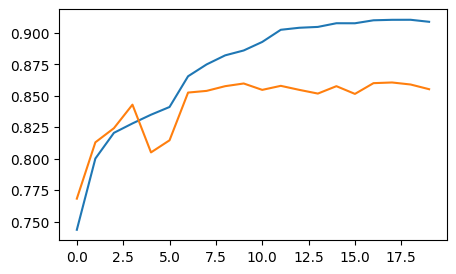

In [45]:
plt.figure(figsize=(5, 3))
plt.plot(sleepeeghist.history["accuracy"])
plt.plot(sleepeeghist.history["val_accuracy"])

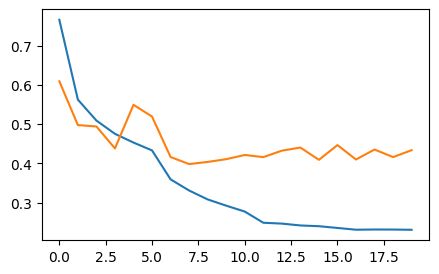

In [46]:
plt.figure(figsize=(5, 3))
plt.plot(sleepeeghist.history["loss"])
plt.plot(sleepeeghist.history["val_loss"])

In [47]:
pp_X_train = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_train])
pp_X_val = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_val])
pp_X_test = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_test])

In [48]:
pp_X_train.shape

(34269, 3000, 1)

In [49]:
sleepeeghist2 = sleep_eegnet_model.fit(
    pp_X_train, y_train, batch_size=64, epochs=20, validation_data=(pp_X_val, y_val), callbacks=callbacks_list
)


Epoch 1/20
536/536 [==============================] - ETA: 0s - loss: 0.3855 - accuracy: 0.8548
Epoch 1: val_loss did not improve from 0.60957
536/536 [==============================] - 62s 116ms/step - loss: 0.3855 - accuracy: 0.8548 - val_loss: 0.5360 - val_accuracy: 0.8141 - lr: 1.0000e-06
Epoch 2/20
536/536 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8713
Epoch 2: val_loss did not improve from 0.60957
536/536 [==============================] - 61s 114ms/step - loss: 0.3396 - accuracy: 0.8713 - val_loss: 0.4876 - val_accuracy: 0.8332 - lr: 1.0000e-06
Epoch 3/20
536/536 [==============================] - ETA: 0s - loss: 0.3258 - accuracy: 0.8762
Epoch 3: val_loss did not improve from 0.60957
536/536 [==============================] - 61s 114ms/step - loss: 0.3258 - accuracy: 0.8762 - val_loss: 0.4770 - val_accuracy: 0.8393 - lr: 1.0000e-06
Epoch 4/20
536/536 [==============================] - ETA: 0s - loss: 0.3115 - accuracy: 0.8821
Epoch 4: val_loss did 

In [49]:
y_pred = sleep_eegnet_model.predict(pp_X_test, batch_size=bs)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1 = f1_score(y_test, y_pred, average="macro")
print(">>> f1 score: {}".format(f1))
report = classification_report(y_test, y_pred)
print(report)

67/67 [==============================] - 2s 25ms/step
>>> f1 score: 0.7797685384628608
              precision    recall  f1-score   support

           0       0.95      0.89      0.91       854
           1       0.52      0.30      0.38       278
           2       0.88      0.92      0.90      1769
           3       0.91      0.89      0.90       563
           4       0.75      0.86      0.81       767

    accuracy                           0.86      4231
   macro avg       0.80      0.77      0.78      4231
weighted avg       0.85      0.86      0.85      4231



In [50]:
accuracy_score(y_test, y_pred)

0.8574805010635783

In [51]:
import pickle

In [52]:
with open('sleepeeg.pkl', 'wb') as file:
    pickle.dump(sleepeeghist2.history, file)